In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wisps
import wisps.simulations as wispsim
import matplotlib as mpl
import astropy.units as u
from astropy.coordinates import SkyCoord
import theano
import theano.tensor as T
import pandas as pd
import pymc3 as pm
import seaborn as sns 
%matplotlib inline

In [2]:
#import theano.tensor as tt

In [3]:
COORDS=SkyCoord([p.coord for p in wisps.OBSERVED_POINTINGS ])

In [4]:
galc=COORDS.transform_to('galactic')

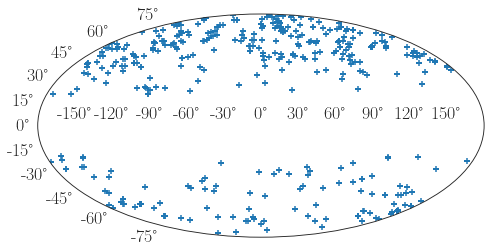

In [5]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(galc.l.wrap_at(180*u.degree).radian,galc.b.wrap_at(90*u.degree).radian, marker='+')

In [6]:
LS=galc.l.radian

In [7]:
BS=galc.b.radian

In [8]:
Rsun=8300.
Zsun=27.

In [9]:
def density_function(r, z, h):
    
    """
    A custom juric density function that only uses numpy arrays for speed
    All units are in pc
    """
    l = 2600. # radial length scale of exponential thin disk 
    
    zpart=(1./np.cosh(abs(z-Zsun)/(2*h)))**2
    rpart=np.exp(-(r-Rsun)/h)
    
    return zpart*rpart

In [10]:
def sample_distances(nsample=1000):
    """
    sample the galaxy given a scale height
    
    """
    def logp(r, z, d, h):
        return np.log10((d**2)*density_function(r, z, h))

    with pm.Model() as model:
        
        l=pm.Uniform('l', lower=np.nanmin(LS), upper=np.nanmax(LS) , observed=LS)
        b=pm.Uniform('b', lower=np.nanmin(BS), upper=np.nanmax(BS),  observed=BS)
        h=pm.Uniform('h', lower=50., upper=1000., observed=350)
        d=pm.Uniform('d', lower=h/100, upper=10*h, testval=5*h, shape=len(BS))

        r=pm.Deterministic('r', np.sqrt( (d * np.cos( b ) )**2 + Rsun * (Rsun - 2 * d * np.cos( b ) * np.cos( l ) ) ))
        z=pm.Deterministic('z', Zsun+ d * np.sin( b - np.arctan( Zsun / Rsun) ))
        
        like = pm.DensityDist('likelihood', logp, observed={
                             'r': r, 'z': z, 'd':d, 'h':h})

        trace = pm.sample(draws=int(nsample), cores=2, step=pm.Metropolis())
    return trace, model


In [11]:
tr, model=sample_distances(nsample=1000)

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [d]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 3231.02draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [12]:
#cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)

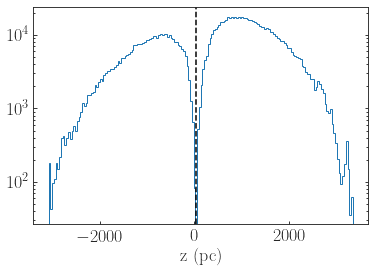

In [13]:
h=plt.hist(np.concatenate(tr['z']),  bins='auto', histtype='step')
plt.axvline(27, c='k', linestyle='--')
plt.xlabel('z (pc)', fontsize=18)
plt.yscale('log')

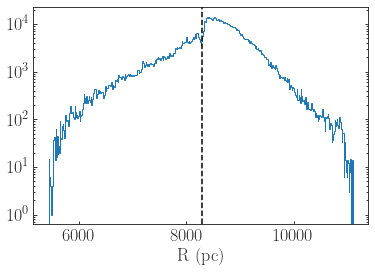

In [14]:
h=plt.hist(np.concatenate(tr['r']),  bins='auto', histtype='step')
plt.axvline(8300., c='k', linestyle='--')
plt.xlabel('R (pc)', fontsize=18)
plt.yscale('log')

Text(0, 0.5, 'Z (pc)')

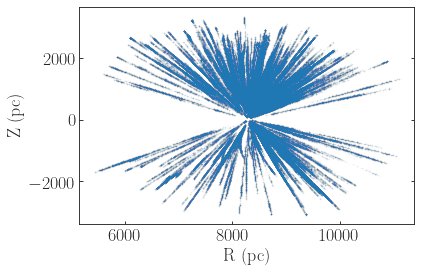

In [15]:
plt.scatter(np.concatenate(tr['r']) , np.concatenate(tr['z']), s=1., alpha=0.01)
#plt.axvline(8300., c='k', linestyle='--')
#plt.axhline(27, c='k', linestyle='--')
plt.xlabel('R (pc)', fontsize=18)
plt.ylabel('Z (pc)', fontsize=18)

In [16]:
#p=plt.plot(tr.d, "k", alpha=0.01)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1ca20b5588>,
      dtype=object)

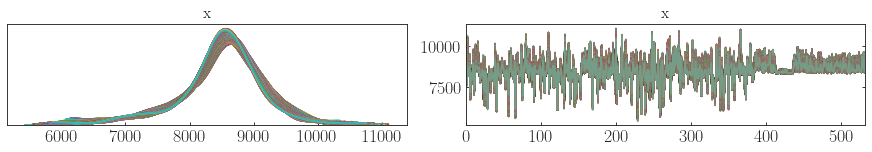

In [25]:
pm.traceplot(tr.r)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2dcf0240>,
      dtype=object)

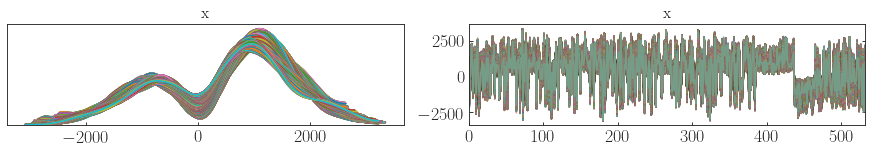

In [18]:
pm.traceplot(tr.z)

In [26]:
samples=np.array([np.concatenate(tr.z), np.concatenate(tr.r)])

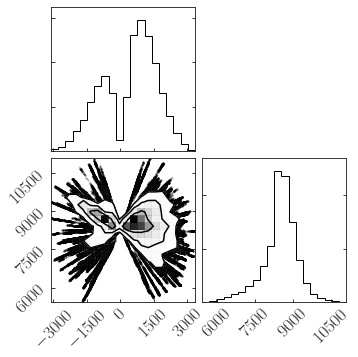

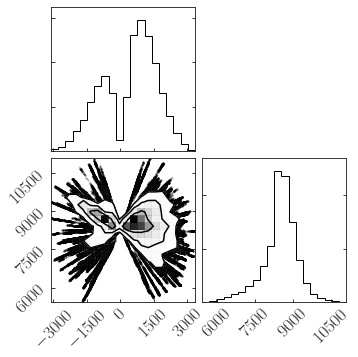

In [27]:
import corner
corner.corner(samples.T)

In [28]:
import wisps.simulations as wispsim

In [29]:
dists=np.load(wisps.OUTPUT_FILES+'/bayesian_pointings.pkl', allow_pickle=True)

In [30]:
rs=dists['rs']
zs=dists['zs']

In [31]:
from matplotlib.colors import Normalize

In [32]:
hs=[h for h in rs.keys()]

In [33]:
cnorm=Normalize(hs[0], hs[-1])

In [34]:
cmap = sns.cubehelix_palette(reverse=True, as_cmap=True)

In [35]:
import matplotlib as mpl

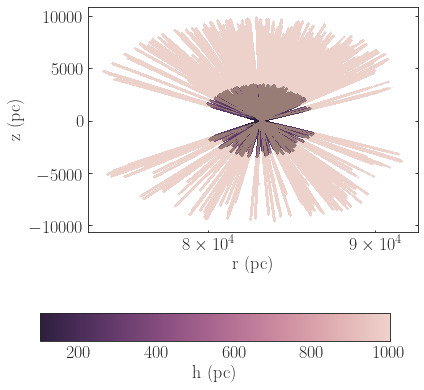

In [36]:
fig, ax=plt.subplots()

for k in hs:
    ax.scatter(rs[k], zs[k], color=cmap(cnorm(k)), alpha=0.01, s=1., marker='.' )
    
ax.set_xscale('log')

ax.set_xlabel('r (pc)', fontsize=18)
ax.set_ylabel('z (pc)', fontsize=18)

ax2=fig.add_axes([0.1, -0.2, 0.81, 0.1])



cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                norm=cnorm,
                            orientation='horizontal')

plt.tight_layout()

cb1.set_label('h (pc)', fontsize=18)

plt.savefig(wisps.OUTPUT_FIGURES+'/galactic_distribution_sim.jpeg', bbox_inches='tight')